In [1]:
import sys
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time as time
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import colors
from netCDF4 import Dataset
from cartopy.io.img_tiles import GoogleTiles
from glob import glob
from scipy.interpolate import griddata
import os.path
from os import path
import requests
from scipy.stats import mode
from pandas import to_datetime
import warnings

In [2]:
#
# User specified variables
#
archive_data_path = '/uufs/chpc.utah.edu/common/home/horel-group/archive'
ccyymmdd = '20191210'
hh = '00'
model = 'nam'
fhr = 84
region = 'WM'

In [3]:
#
# User defined functions for simple plotting to debug code
#
# Simple 2-d plot
#
def simple2dplot(a2darray):
    fig = plt.figure()
    plt.pcolormesh(a2darray)
    plt.show
#
# Simple histogram
#
def simplehisto(data):
    plt.hist(data.flatten())
    plt.show

In [4]:
#
# Class defines information for hillshade relief
#
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

In [5]:
#
# Map regions
#
map_regions = {
    'UT':(-114.7, -108.5, 36.7, 42.5),
    'WM':(-117, -108.5, 43, 49),
    'CO':(-110, -104, 36, 41.9),
    'SJ':(-109.0, -107.0, 37, 38.5),
    'SN':(-123.5, -116.0, 33.5, 41),
    'LT':(-121.5,-119.25,38.0,40.0),
    'WE':(-125, -102.5, 31.0, 49.2),
    'NW':(-125, -116.5, 42.0, 49.1),
    'SP':(-122.5,-120.5,46.4,48.4),
    'NU':(-113.4, -110.7, 39.5, 41.9),
    'WR':(-112.35, -111.05, 40.2, 41.5)
    }

In [6]:
#
# Accumulation period should be 24
#
accumperiod = 24
#
# Define left longitude, right longitude, bottom latitude, top latitude, center longitude, center latitude, and the hill-shade detail (bigger 
# number means more detail) for plan-view maps
#
left_longitude, right_longitude, bottom_latitude, top_latitude = map_regions[region]
centlon = (left_longitude + right_longitude)/2
centlat = (bottom_latitude + top_latitude)/2
hill_shade_detail = int(np.maximum(10/((top_latitude-bottom_latitude)**.5),5))

In [7]:
#
# Open model data files
#
model_file_string = archive_data_path+'/'+ccyymmdd+'/models/'+model+'ds/'+ccyymmdd+hh+'/'
model_file_list = glob(model_file_string + '*.nc')
model_file_list = np.array(model_file_list)[np.argsort(model_file_list)]
model_data = xr.open_mfdataset(model_file_list, combine='by_coords')

In [8]:
#
# Extract latitude and longitude and put into 2D array
# 
model_latitude_tmp = model_data.lat.values
model_longitude_tmp = model_data.lon.values
left_longitude_index=min(range(len(model_longitude_tmp)), key=lambda i: abs(model_longitude_tmp[i]-left_longitude))
right_longitude_index=min(range(len(model_longitude_tmp)), key=lambda i: abs(model_longitude_tmp[i]-right_longitude))
bottom_latitude_index=min(range(len(model_latitude_tmp)), key=lambda i: abs(model_latitude_tmp[i]-bottom_latitude))
top_latitude_index=min(range(len(model_latitude_tmp)), key=lambda i: abs(model_latitude_tmp[i]-top_latitude))
model_longitude, model_latitude = np.meshgrid(model_longitude_tmp[left_longitude_index:right_longitude_index],model_latitude_tmp[bottom_latitude_index:top_latitude_index])
#
# Determine end and start times of the accumulation period
#
accumend = int(fhr/3+1)
accumstart = int(accumend-accumperiod/3)
accumendtime = datetime.strftime(pd.to_datetime(model_data.time.values[accumend-1]),'%Y-%m-%d %H:%M UTC')
accumstarttime = datetime.strftime(pd.to_datetime(model_data.time.values[accumstart-1]),'%Y-%m-%d %H:%M UTC')
#
# Output to screen
#
print ('plotting',accumperiod,'hr accumulation beginning',accumstarttime,'ending ',accumendtime)
print ('Involves summing 3-h accumulations for periods ending below')
print (model_data.dqsf.isel(time=slice(accumstart,accumend)).time.values)
#
# Extract downscaled snowfall, undownscaled snowfall, and downscaled qpf for the accmulation period and convert to inches
#
model_dqsf = model_data.dqsf.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(bottom_latitude_index,top_latitude_index),time=slice(accumstart,accumend)).sum(dim="time").values/25.4
model_dqsf_units='inches'
model_qsf = model_data.qsf.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(bottom_latitude_index,top_latitude_index),time=slice(accumstart,accumend)).sum(dim="time").values/25.4
model_qsf_units='inches'
model_dqpf = model_data.qsf.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(bottom_latitude_index,top_latitude_index),time=slice(accumstart,accumend)).sum(dim="time").values/254
model_dqpf_units='inches'
model_max_wbzh = model_data.wbzh.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(bottom_latitude_index,top_latitude_index),time=slice(accumstart,accumend)).max(dim="time").values
model_min_wbzh = model_data.wbzh.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(bottom_latitude_index,top_latitude_index),time=slice(accumstart,accumend)).min(dim="time").values
model_wbzh_units='meters'
#
# Calculate the mean SLR based on the downscaled qpf and qsf where snowfall > 0.5 inches  
#
model_mean_slr = xr.where(model_dqsf >= 0.5, model_dqsf/model_dqpf, np.nan)

plotting 24 hr accumulation beginning 2019-12-12 12:00 UTC ending  2019-12-13 12:00 UTC
Involves summing 3-h accumulations for periods ending below
['2019-12-12T15:00:00.000000000' '2019-12-12T18:00:00.000000000'
 '2019-12-12T21:00:00.000000000' '2019-12-13T00:00:00.000000000'
 '2019-12-13T03:00:00.000000000' '2019-12-13T06:00:00.000000000'
 '2019-12-13T09:00:00.000000000' '2019-12-13T12:00:00.000000000']


/uufs/chpc.utah.edu/common/home/u0028395/software/pkg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/uufs/chpc.utah.edu/common/home/u0028395/software/pkg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [9]:
#
# Determine the corresponding date and name for the NOHRSC data and file, respectively
# Stop if validation time does not equate to 1200 UTC
#
ccyymmddhh = ccyymmdd+hh
validtime = (datetime.strptime(ccyymmddhh, "%Y%m%d%H") + timedelta(hours=fhr)).strftime("%Y%m%d%H")
#if validtime[-2:] != '00' and validtime[-2:] != '12':
if validtime[-2:] != '12':
    raise(ValueError('Validation time',validtime,'does not equal 00 or 12 UTC, exiting'))
nohrsc_file = './sfav2_CONUS_24h_'+validtime+'.nc'
try:
    nohrsc_data = xr.open_dataset(nohrsc_file)
except:
    print('nohrsc file',nohrsc_file,'not found, trying to download')
    url = 'https://www.nohrsc.noaa.gov/snowfall/data/'+str(validtime[:6])+'/sfav2_CONUS_24h_'+validtime+'.nc'
    r=requests.get(url, allow_redirects=True)
    open('sfav2_CONUS_24h_'+validtime+'.nc','wb').write(r.content)
    try:
        print('trying to read file')
        nohrsc_data = xr.open_dataset(nohrsc_file)
    except:
        raise(ValueError('nohrsc data',nohrsc_file,'not available'))
#
# Extract latitude and longitude and put into 2D array
#
print('NOHRSC data found for',validtime)
nohrsc_latitude_tmp = nohrsc_data.lat.values
nohrsc_longitude_tmp = nohrsc_data.lon.values
left_longitude_index=min(range(len(nohrsc_longitude_tmp)), key=lambda i: abs(nohrsc_longitude_tmp[i]-left_longitude))-2
right_longitude_index=min(range(len(nohrsc_longitude_tmp)), key=lambda i: abs(nohrsc_longitude_tmp[i]-right_longitude))+2
bottom_latitude_index=min(range(len(nohrsc_latitude_tmp)), key=lambda i: abs(nohrsc_latitude_tmp[i]-bottom_latitude))+2
top_latitude_index=min(range(len(nohrsc_latitude_tmp)), key=lambda i: abs(nohrsc_latitude_tmp[i]-top_latitude))-2
#
# Latitude decreases with increasing index, so swapping top_latitude_index and bottom_latitude_index order for slice below
#
nohrsc_longitude, nohrsc_latitude = np.meshgrid(nohrsc_longitude_tmp[left_longitude_index:right_longitude_index],nohrsc_latitude_tmp[top_latitude_index:bottom_latitude_index])
#
# Extract analyzed snowfall (dataset unit is meters), convert to inches
#
nohrsc_snow = nohrsc_data.Data.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(top_latitude_index,bottom_latitude_index))*39.37
nohrsc_snow_units='inches'

NOHRSC data found for 2019121312


In [10]:
#
# Determine the corresponding date and name for the nohrsc data and file, respectively
# Stop if validation time does not equate to 1200 UTC
#
nohrsc_pt_time = (datetime.strptime(validtime, "%Y%m%d%H") + timedelta(hours=6)).strftime("%Y%m%d%H")
print(nohrsc_pt_time)
nohrsc_pt_file = './snowfall_'+nohrsc_pt_time+'_e.txt'
try:
    raw=pd.read_csv(nohrsc_pt_file,sep='|',header=1).rename(columns={'DateTime_Report(UTC)':'DateTimeUTC'})
except:
    print('nohrsc point file',nohrsc_pt_file,'not found, trying to download')
    url = 'https://www.nohrsc.noaa.gov/nsa/discussions_text/National/snowfall/'+str(validtime[:6])+'/snowfall_'+nohrsc_pt_time+'_e.txt'
    print(url)
    r=requests.get(url, allow_redirects=True)
    open('snowfall_'+nohrsc_pt_time+'_e.txt','wb').write(r.content)
    try:
        print('Dowloaded, trying to read file')
        raw=pd.read_csv(nohrsc_pt_file,sep='|',header=1).rename(columns={'DateTime_Report(UTC)':'DateTimeUTC'})
    except:
        raise(ValueError('nohrsc point data',nohrsc_pt_file,'not available'))
#
#  Extract 24-h totals between 09:00 and 15:00Z in the region of interest
#
nohrsc_snow_at_points = raw.loc[(raw['DateTimeUTC'] >= validtime[:4]+'-'+validtime[4:6]+'-'+validtime[6:8]+' 09:00') 
                    & (raw['DateTimeUTC'] <= validtime[:4]+'-'+validtime[4:6]+'-'+validtime[6:8]+' 15:00')] \
                    .loc[raw['Duration'] == 24.0] \
                    .loc[(raw['Latitude'] >= bottom_latitude) & (raw['Latitude'] <= top_latitude)] \
                    .loc[(raw['Longitude'] >= left_longitude) & (raw['Longitude'] <= right_longitude)]
print(nohrsc_snow_at_points.to_string())
total_rows = len(nohrsc_snow_at_points)
print(total_rows)
#for x in range(0, total_rows):
#    print(nohrsc_snow_at_points.iloc[x,0],nohrsc_snow_at_points.iloc[x,7])

2019121318
            Station_Id                                               Name  Latitude  Longitude  Elevation Physical_Element       DateTimeUTC  Amount Amount_Units  Duration Duration_Units  Zip_Code  Unnamed: 12
4     45.4219_113.1020  MT BEAVERHEAD 3 NNE POLARIS COCORAHS COCORAHS ...  45.42190 -113.10200  6640 feet         snowfall  2019-12-13 14:00   1.500           in      24.0          hours   59725.0          NaN
34    47.8305_110.6600  MT CHOUTEAU FORT BENTON COOP CO-OP OBSERVER (F...  47.83050 -110.66000  2648 feet         snowfall  2019-12-13 15:00   3.400           in      24.0          hours   59442.0          NaN
49               ABTM8                                           ALBERTON  47.00360 -114.47810  3051 feet         snowfall  2019-12-13 15:00   0.200           in      24.0          hours   59820.0          NaN
591              BDGM8                                         BRIDGER 2N  45.32610 -108.90910  3593 feet         snowfall  2019-12-13 14:00   0.000 

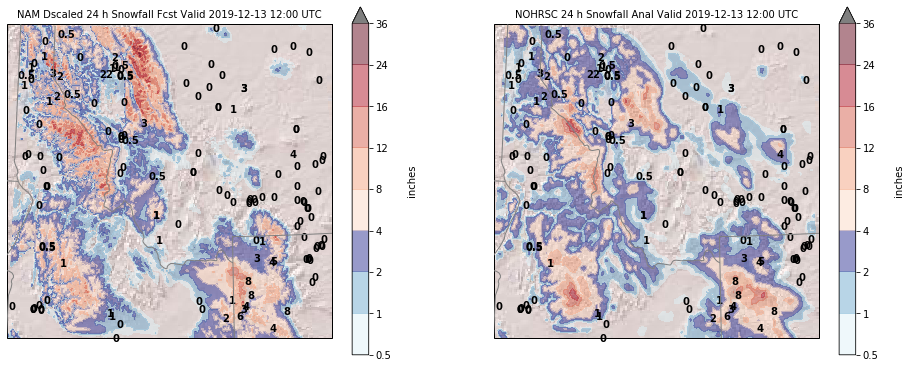

In [11]:
#
# Define color fill levels and colors
#
snow_color_fill_levels = ([0.5,1,2,4,8,12,16,24,36])
snow_fill_colors = ['#E0F3F8',
               '#73ADD1',
               '#323696',
               '#FDDBC7',
               '#F4a582',
               '#D6614E',
               '#B1182B',
               '#670A1F',
               'black']
snow_color_map = colors.ListedColormap(snow_fill_colors[:-1], name='snowmap')
snow_color_map.set_over(snow_fill_colors[-1])
snow_vmin, snow_vmax = snow_color_fill_levels[0], snow_color_fill_levels[-1]
snow_norml = colors.BoundaryNorm(snow_color_fill_levels, len(snow_fill_colors)-1)
#
# Define where to draw ticks for color bar
#
color_bar_ticks = [str(x) for x in snow_color_fill_levels]
#
# Set figure size and projection information
#
plt.rcParams['figure.figsize'] = (16,16)
proj = ccrs.LambertConformal(central_longitude=centlon,central_latitude=centlat, standard_parallels=[40])
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none')
fig, axes = plt.subplots(1, 2, subplot_kw=dict(projection=proj))
#
#
#  Left plot (axes[0]) ----------------------------------------------------------------------------------------
#
#  Define region (left lon, right lon, bottom lat, top lat)
#
axes[0].set_extent([left_longitude, right_longitude, bottom_latitude, top_latitude])
#
#  Shaded relief, state borders
#
axes[0].add_image(ShadedReliefESRI(), hill_shade_detail)
axes[0].add_feature(cfeature.BORDERS, zorder=10)
axes[0].add_feature(states_provinces, edgecolor='gray', zorder=10)
#
# Model dqsf as color filled contour plot
#
snow_fill = axes[0].contourf(model_longitude,
                         model_latitude,
                         model_dqsf,
                         levels=snow_color_fill_levels, 
                         vmin=snow_vmin, 
                         vmax=snow_vmax, 
                         norm=snow_norml, 
                         extend='max', 
                         alpha=0.5,
                         cmap=snow_color_map,
                         zorder=2,
                         transform=ccrs.PlateCarree())
if top_latitude - bottom_latitude < 2.5 and right_longitude - left_longitude < 2.5:
    axes[0].contour(model_longitude,
                model_latitude,
                model_dqsf,
                levels=snow_color_fill_levels, 
                alpha=1,
                linewidths=0.7,
                colors='gray',
                transform=ccrs.PlateCarree())
total_rows = len(nohrsc_snow_at_points)
for x in range(0, total_rows):
    point_loc_value=int(nohrsc_snow_at_points.iloc[x,7]*2.)/2.
    if point_loc_value >= 1.0:
        point_loc_value=int(point_loc_value)
    elif point_loc_value == 0.0:
        point_loc_value=int(point_loc_value)
    axes[0].text(nohrsc_snow_at_points.iloc[x,3],nohrsc_snow_at_points.iloc[x,2], point_loc_value,
            horizontalalignment='center',verticalalignment='center',color='black',weight='bold',size='10',
            transform=ccrs.PlateCarree())
#
# Plot colorbar
#
colorbar = plt.colorbar(snow_fill,shrink=.4,label='\n'+nohrsc_snow_units,ax=axes[0])
colorbar.set_ticks(snow_color_fill_levels)
colorbar.set_ticklabels(color_bar_ticks)
#
# Plot title
#
title = '%s Dscaled %s h Snowfall Fcst Valid %s'%(model.upper(),accumperiod,accumendtime)
axes[0].set_title(title,fontsize=10)
#
#
#  Right plot (axes[1]) ----------------------------------------------------------------------------------------
#
#  Define region (left lon, right lon, bottom lat, top lat)
#
axes[1].set_extent([left_longitude, right_longitude, bottom_latitude, top_latitude])
#
#  Shaded relief, state borders
#
axes[1].add_image(ShadedReliefESRI(), hill_shade_detail)
axes[1].add_feature(cfeature.BORDERS, zorder=10)
axes[1].add_feature(states_provinces, edgecolor='gray', zorder=10)
#
# nohrsc analyzed snowfall as color filled contour plot
#
snow_fill = axes[1].contourf(nohrsc_longitude,
                         nohrsc_latitude,
                         nohrsc_snow,
                         levels=snow_color_fill_levels, 
                         vmin=snow_vmin, 
                         vmax=snow_vmax, 
                         norm=snow_norml, 
                         extend='max', 
                         alpha=0.5,
                         cmap=snow_color_map,
                         zorder=2,
                         transform=ccrs.PlateCarree())
if top_latitude - bottom_latitude < 2.5 and right_longitude - left_longitude < 2.5:
    axes[1].contour(nohrsc_longitude,
                nohrsc_latitude,
                nohrsc_snow,
                levels=snow_color_fill_levels, 
                alpha=1,
                linewidths=0.7,
                colors='gray',
                transform=ccrs.PlateCarree()) 
total_rows = len(nohrsc_snow_at_points)
for x in range(0, total_rows):
    point_loc_value=int(nohrsc_snow_at_points.iloc[x,7]*2.)/2.
    if point_loc_value >= 1.0:
        point_loc_value=int(point_loc_value)
    elif point_loc_value == 0.0:
        point_loc_value=int(point_loc_value)
    axes[1].text(nohrsc_snow_at_points.iloc[x,3],nohrsc_snow_at_points.iloc[x,2], point_loc_value,
            horizontalalignment='center',verticalalignment='center',color='black',weight='bold',size='10',
            transform=ccrs.PlateCarree())
#
# Plot colorbar
#
colorbar = plt.colorbar(snow_fill,shrink=.4,label='\n'+nohrsc_snow_units,ax=axes[1])
colorbar.set_ticks(snow_color_fill_levels)
colorbar.set_ticklabels(color_bar_ticks)
#
# Plot title
#
title = 'NOHRSC %s h Snowfall Anal Valid %s'%(accumperiod,accumendtime)
axes[1].set_title(title,fontsize=10)
gfile = 'Nohrsc-pt-valid_%s.png'%(region)
plt.savefig(gfile, bbox_inches='tight')